In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
def remove_high_corr_features(df, threshold=0.95):
    """Remove features with correlation > threshold using upper triangle"""
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    drop_cols = [col for col in upper.columns if any(upper[col] > threshold)]
    return df.drop(columns=drop_cols), drop_cols


In [12]:
def main():
    # Reproducibility
    np.random.seed(42)
    
    # Load and clean data
    df = pd.read_csv("data/curated-solubility-dataset.csv")
    
    # Handle MolLogP outliers
    df = df[(df["Solubility"] <= 1) & (df["Solubility"] >= -9)]
    
    # Drop non-feature columns
    non_features = ["ID","Name","InChI","InChIKey","SMILES","SD","Ocurrences","Group"]
    df = df.drop(columns=non_features)
    
    # Safety check: Verify numeric features
    assert df.select_dtypes(exclude=np.number).empty, "Non-numeric features present" 
    
    # Split data
    y = df["Solubility"]
    X = df.drop(columns=["Solubility"])
    
    # Remove correlated features
    X, removed = remove_high_corr_features(X, 0.95)
    print(f"Removed high-corr features: {removed}")  #! Transparency
    
    # Train-validation split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Optimized XGBoost configuration
    model = XGBRegressor(
        objective="reg:squarederror",
        eval_metric="rmse",
        n_estimators=2000, 
        learning_rate=0.02, 
        max_depth=6,      
        subsample=0.8,       
        colsample_bytree=0.7,
        reg_alpha=0.1,       #! L1 
        reg_lambda=1.0,      #! L2 
        early_stopping_rounds=20,  
        random_state=42
    )
    
    # Training with early stopping
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=50
    )
    
    # Evaluation
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)
    print(f"\nValidation RMSE: {rmse:.4f}")
    print(f"Validation R²: {r2:.4f}")
    
    #plots
    plt.figure(figsize=(10,6))
    plot_importance(model, max_num_features=15)
    plt.title("XGBoost Feature Importance")
    plt.show()

Removed high-corr features: ['HeavyAtomCount', 'NumValenceElectrons', 'LabuteASA']
[0]	validation_0-rmse:2.16041
[50]	validation_0-rmse:1.35684
[100]	validation_0-rmse:1.17418
[150]	validation_0-rmse:1.12710
[200]	validation_0-rmse:1.10969
[250]	validation_0-rmse:1.09894
[300]	validation_0-rmse:1.08693
[350]	validation_0-rmse:1.07725
[400]	validation_0-rmse:1.07038
[450]	validation_0-rmse:1.06509
[500]	validation_0-rmse:1.06111
[550]	validation_0-rmse:1.05791
[600]	validation_0-rmse:1.05404
[650]	validation_0-rmse:1.05206
[700]	validation_0-rmse:1.04899
[750]	validation_0-rmse:1.04563
[800]	validation_0-rmse:1.04351
[850]	validation_0-rmse:1.04277
[851]	validation_0-rmse:1.04279

Validation RMSE: 1.0426
Validation R²: 0.7722


<Figure size 1000x600 with 0 Axes>

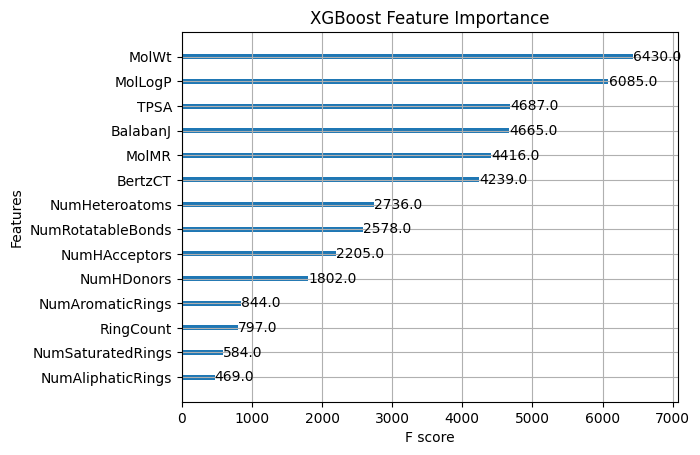

In [13]:
if __name__ == "__main__":
    main()